##Установка необходимых зависимостей

In [ ]:
!pip install --upgrade ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO
from IPython.display import display, Image

Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.9/112.6 GB disk)


##Импорт датасета из Roboflow

In [ ]:
!mkdir /content/datasets
%cd /content/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="8i84IbdANTDtEm9KiTGP")
project = rf.workspace("dataset-wu5i7").project("membranedetection-625")
version = project.version(2)
dataset = version.download("yolov8")

/content/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MembraneDetection-625-2 in yolov8:: 100%|██████████| 1278/1278 [00:00<00:00, 8113.63it/s]


## Обучение модели


При обучении выбран режим детекции объектов (task=detect). Используемая версия YOLO: YOLOv8s - она меньше и быстрее по сравнению с более крупными версиями и её вполне достаточно для выполнения поставленной задачи. Количество эпох (epochs) выбрано экспериментальным путём с опорой на получаемые метрики (plots=True)

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=75 imgsz=800 plots=True

100% 21.5M/21.5M [00:00<00:00, 269MB/s]
Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/datasets/MembraneDetection-625-2/data.yaml, epochs=75, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fa

###Ключевые визуализации для анализа результатов обучения модели

Проверка содержимого папки, в которую сохраняются результатоы обучения YOLOv8

In [ ]:
!ls /content/datasets/runs/detect/train/

args.yaml					    PR_curve.png	 train_batch2277.jpg
confusion_matrix_normalized.png			    R_curve.png		 train_batch2.jpg
confusion_matrix.png				    results.csv		 val_batch0_labels.jpg
events.out.tfevents.1744123624.ebbb2cabca3c.1896.0  results.png		 val_batch0_pred.jpg
F1_curve.png					    train_batch0.jpg	 val_batch1_labels.jpg
labels_correlogram.jpg				    train_batch1.jpg	 val_batch1_pred.jpg
labels.jpg					    train_batch2275.jpg  weights
P_curve.png					    train_batch2276.jpg


Вывод матрицы ошибок (confusion matrix), которая показывает, как часто модель путает классы между собой

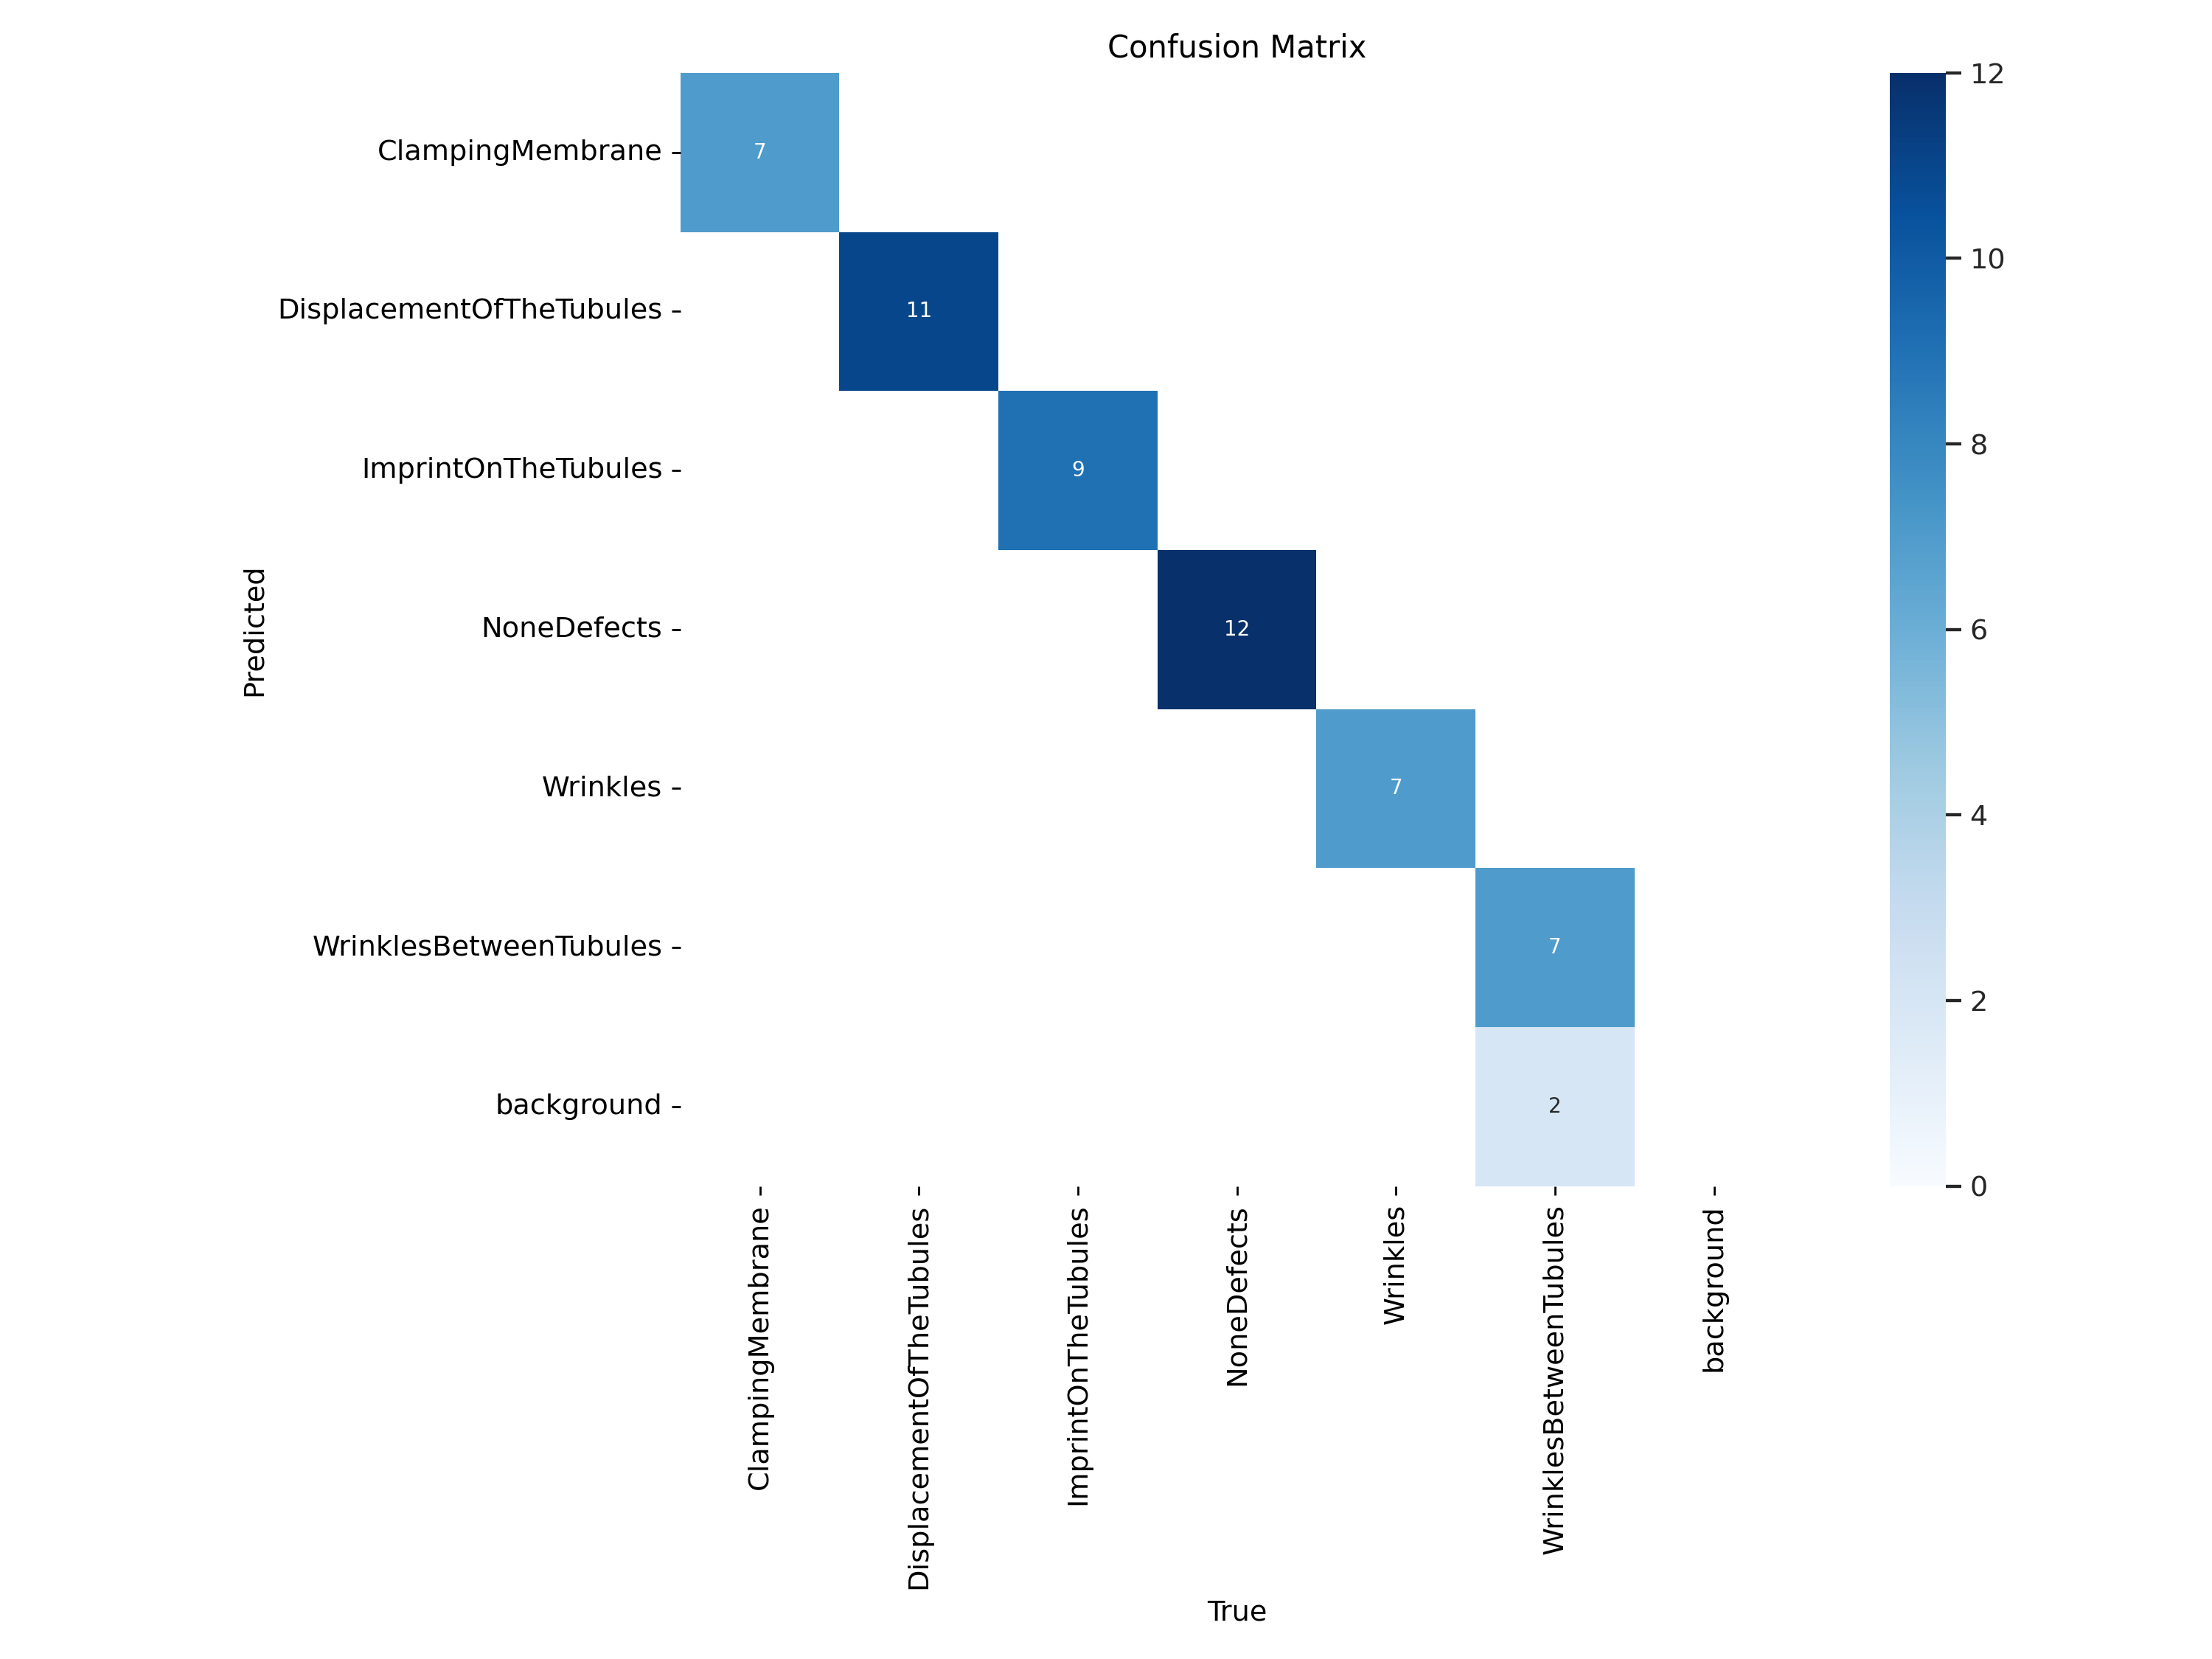

In [ ]:
Image(filename=f'/content/datasets/runs/detect/train/confusion_matrix.png', width=600)

Вывод метрик обучения, включая потери (loss) и точность (mAP), по эпохам.

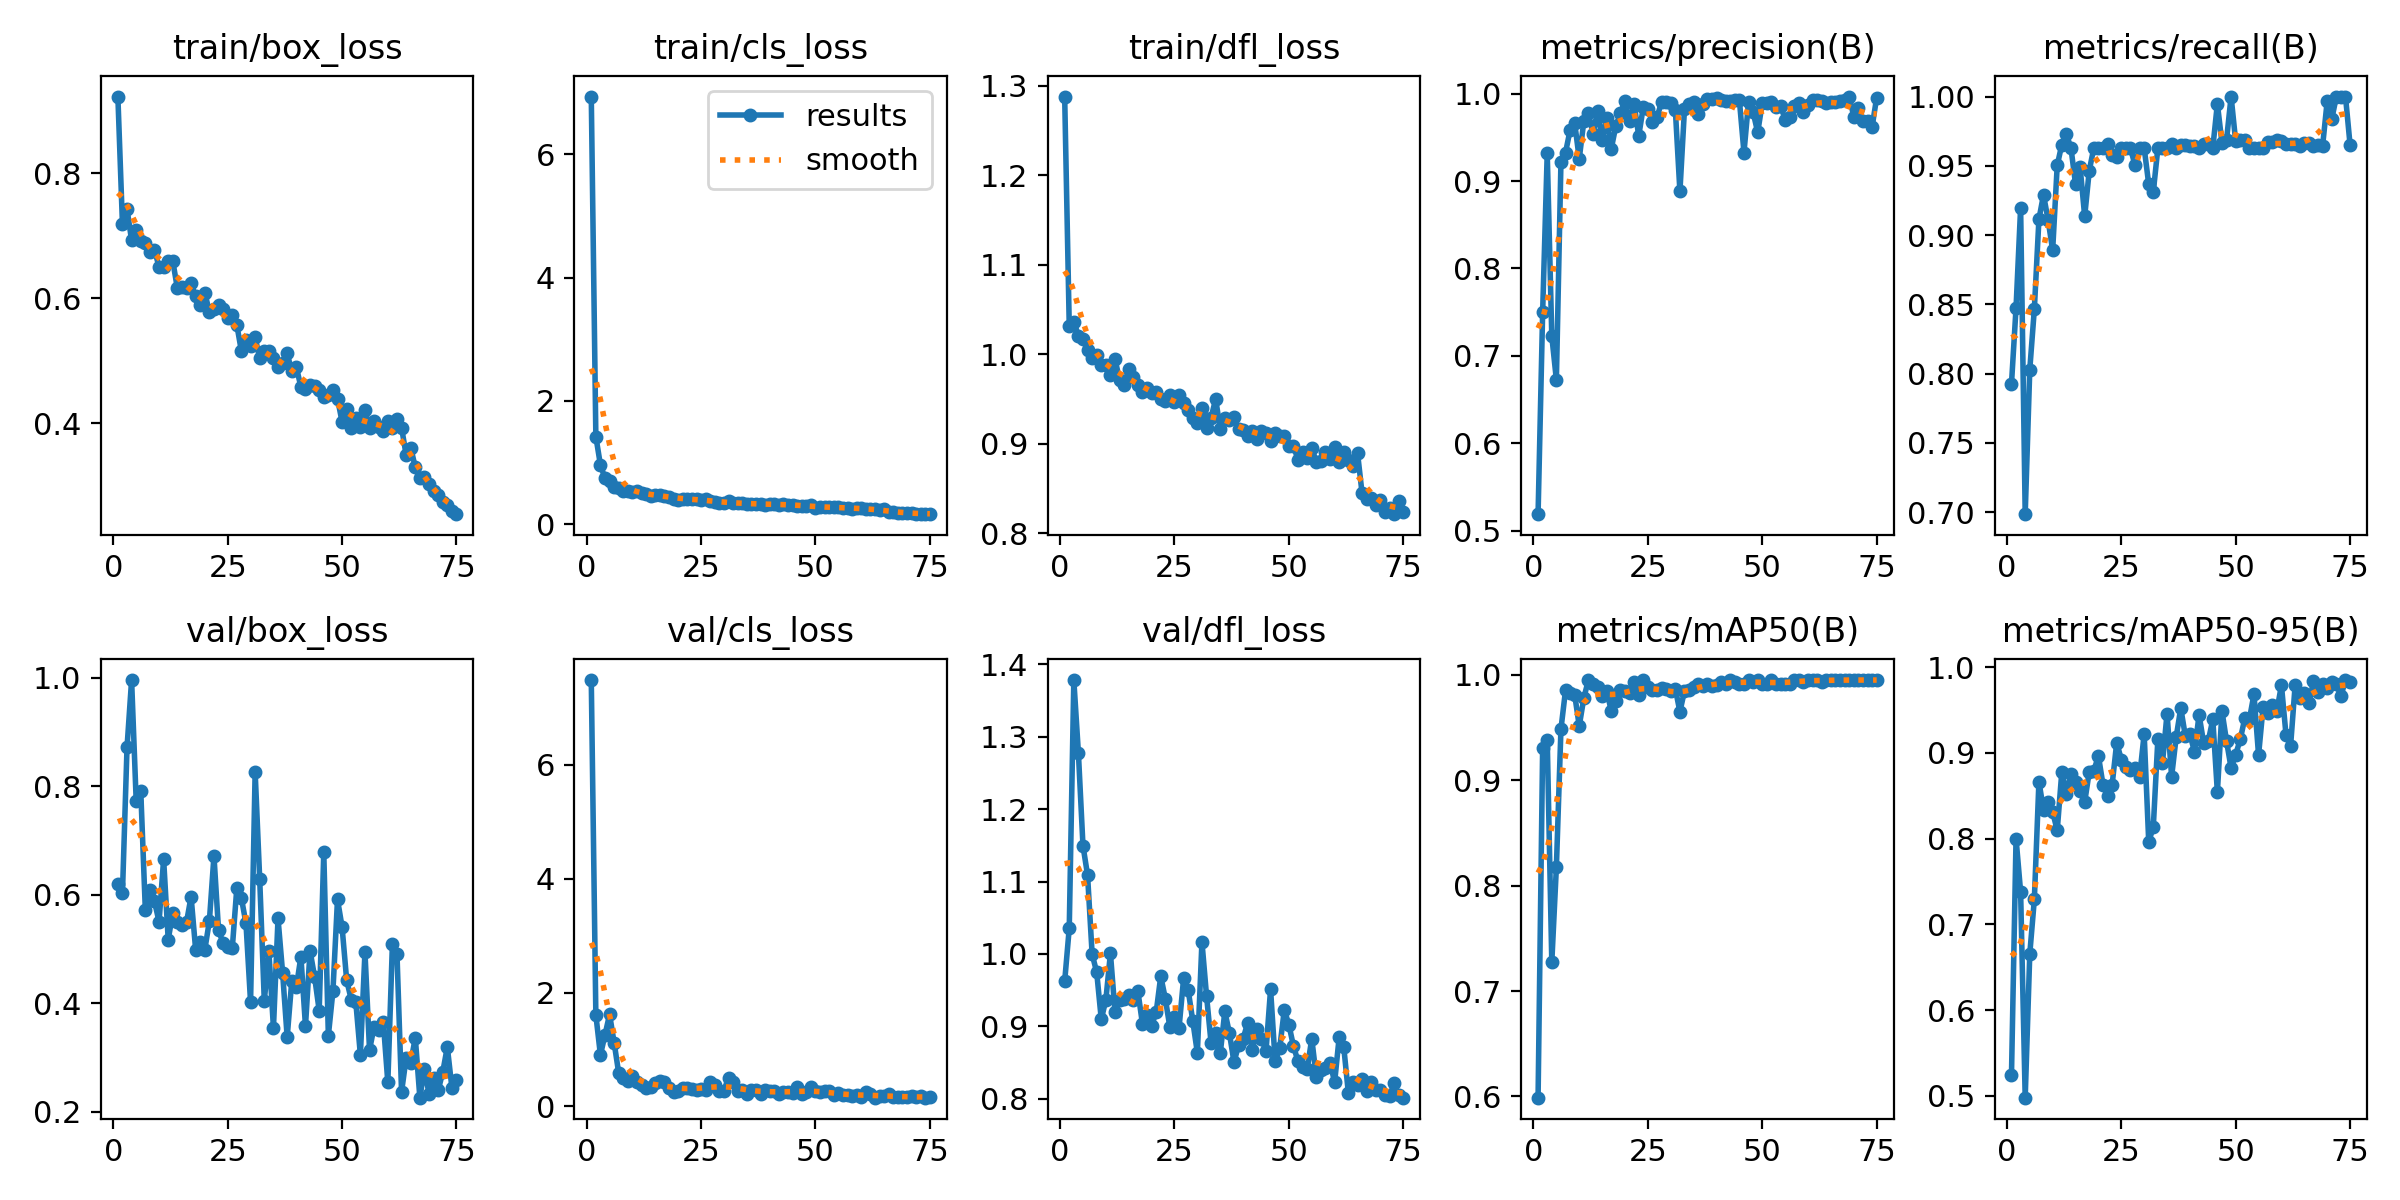

In [ ]:
Image(filename=f'/content/datasets/runs/detect/train/results.png', width=600)

Вывод примера предсказаний модели на валидационном наборе (val_batch0_pred.jpg), который демонстрирует, как модель распознаёт объекты на реальных изображениях.

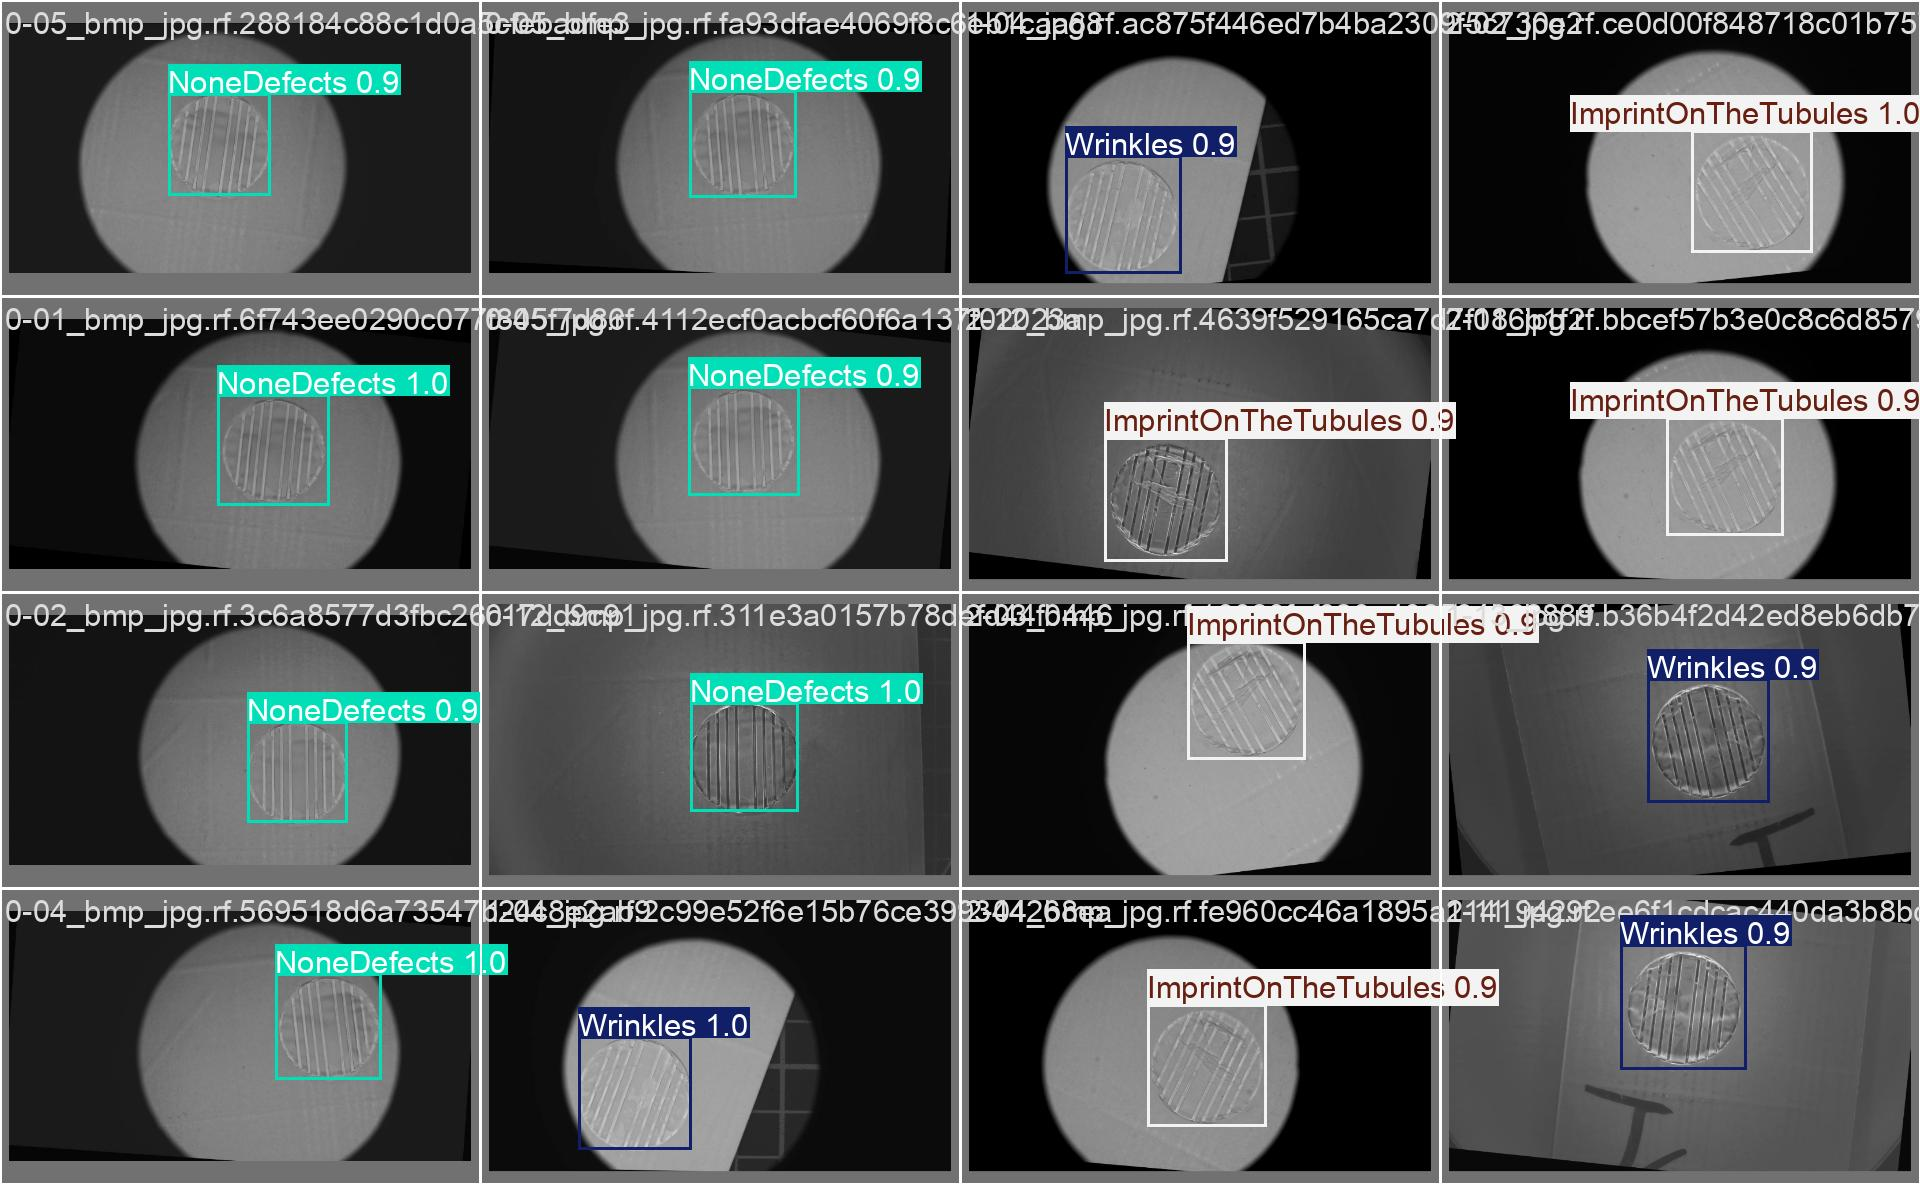

In [ ]:
Image(filename=f'/content/datasets/runs/detect/train/val_batch0_pred.jpg', width=600)

## Валидация обученной модели



In [ ]:
!yolo task=detect mode=val model=/content/datasets/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/MembraneDetection-625-2/valid/labels.cache... 53 images, 0 backgrounds, 0 corrupt: 100% 53/53 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:02<00:00,  1.99it/s]
                   all         53         55      0.962          1      0.995      0.985
      ClampingMembrane          7          7          1          1      0.995      0.995
DisplacementOfTheTubules         11         11      0.934          1      0.995      0.995
   ImprintOnTheTubules          9          9       0.92          1      0.995      0.986
           NoneDefects         12         12      0.939          1      0.995      0.978
              Wrinkles          7          7          1          1      0.995      0.987
WrinklesBetweenTubules          

## Предсказание объектов на тестовом наборе данных

In [ ]:
!yolo task=detect mode=predict model=/content/datasets/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs

image 1/26 /content/datasets/MembraneDetection-625-2/test/images/0-11_bmp_jpg.rf.6d2871f2a6f32cba821f032370fcb976.jpg: 480x800 1 NoneDefects, 40.0ms
image 2/26 /content/datasets/MembraneDetection-625-2/test/images/0-12_jpg.rf.fa2395f40876ec9fedcd7c90a75580cc.jpg: 480x800 1 NoneDefects, 15.6ms
image 3/26 /content/datasets/MembraneDetection-625-2/test/images/0-13_jpg.rf.7e1d658531aa8ef3bb47babcbb6aa2fb.jpg: 480x800 1 NoneDefects, 15.5ms
image 4/26 /content/datasets/MembraneDetection-625-2/test/images/0-13_jpg.rf.c9484ed567c2d4b40990db52f8104314.jpg: 480x800 1 NoneDefects, 15.5ms
image 5/26 /content/datasets/MembraneDetection-625-2/test/images/0-1_jpg.rf.cdadf38d923edfd042951aaf68d40ed5.jpg: 800x800 1 NoneDefects, 23.4ms
image 6/26 /content/datasets/MembraneDetection-625-2/test/images/0-5_jpg.rf.0f94aca4abf20d59d0cc0d1a9b7fc9

Визуализация первых 3-х обработанных изображений из папки с результатами детекции YOLOv8

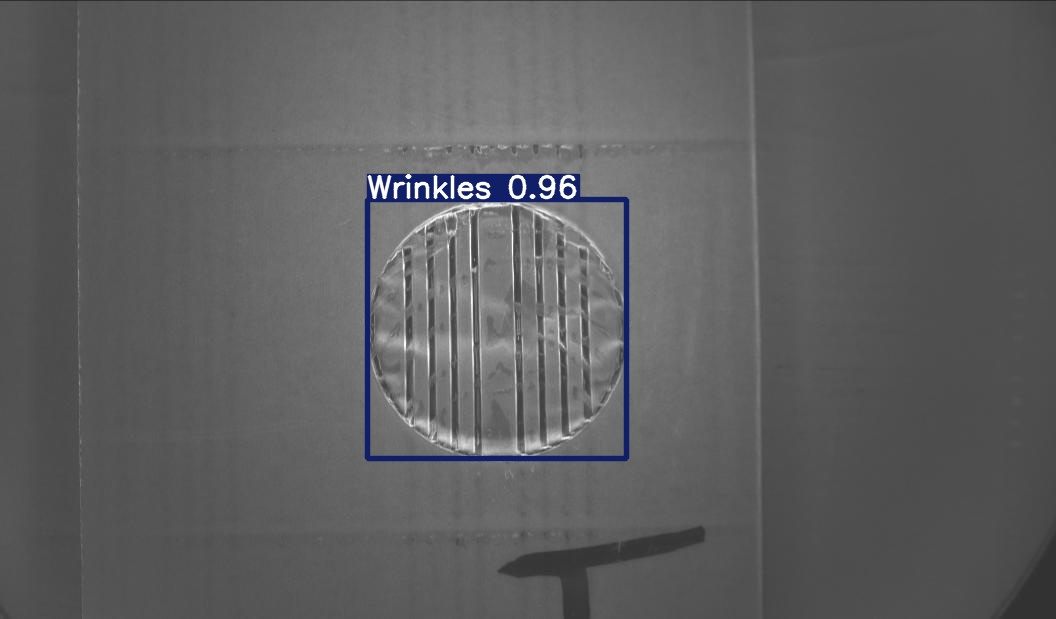

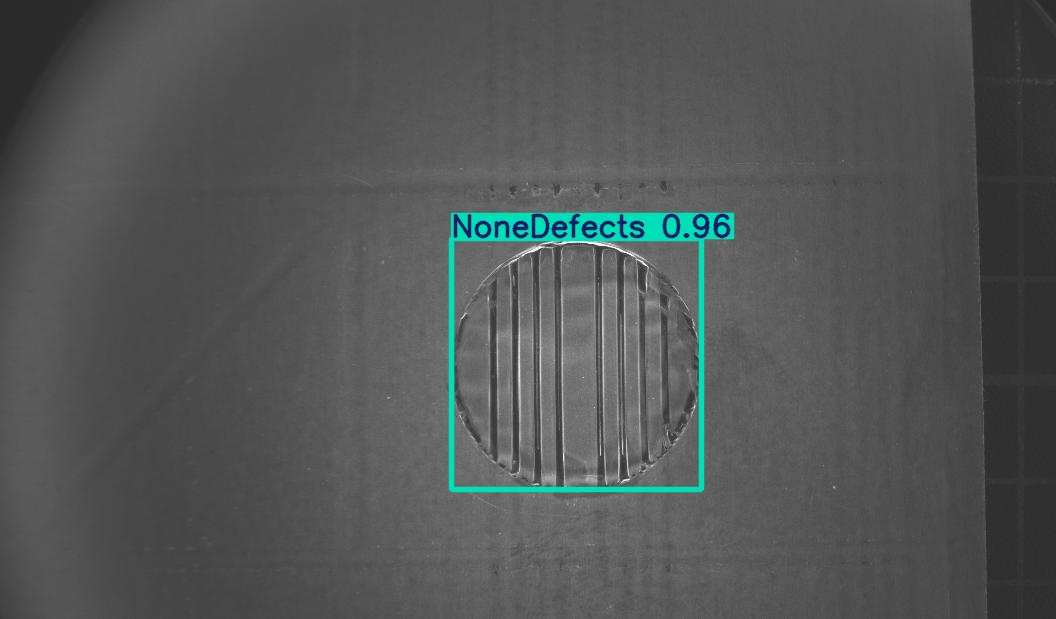

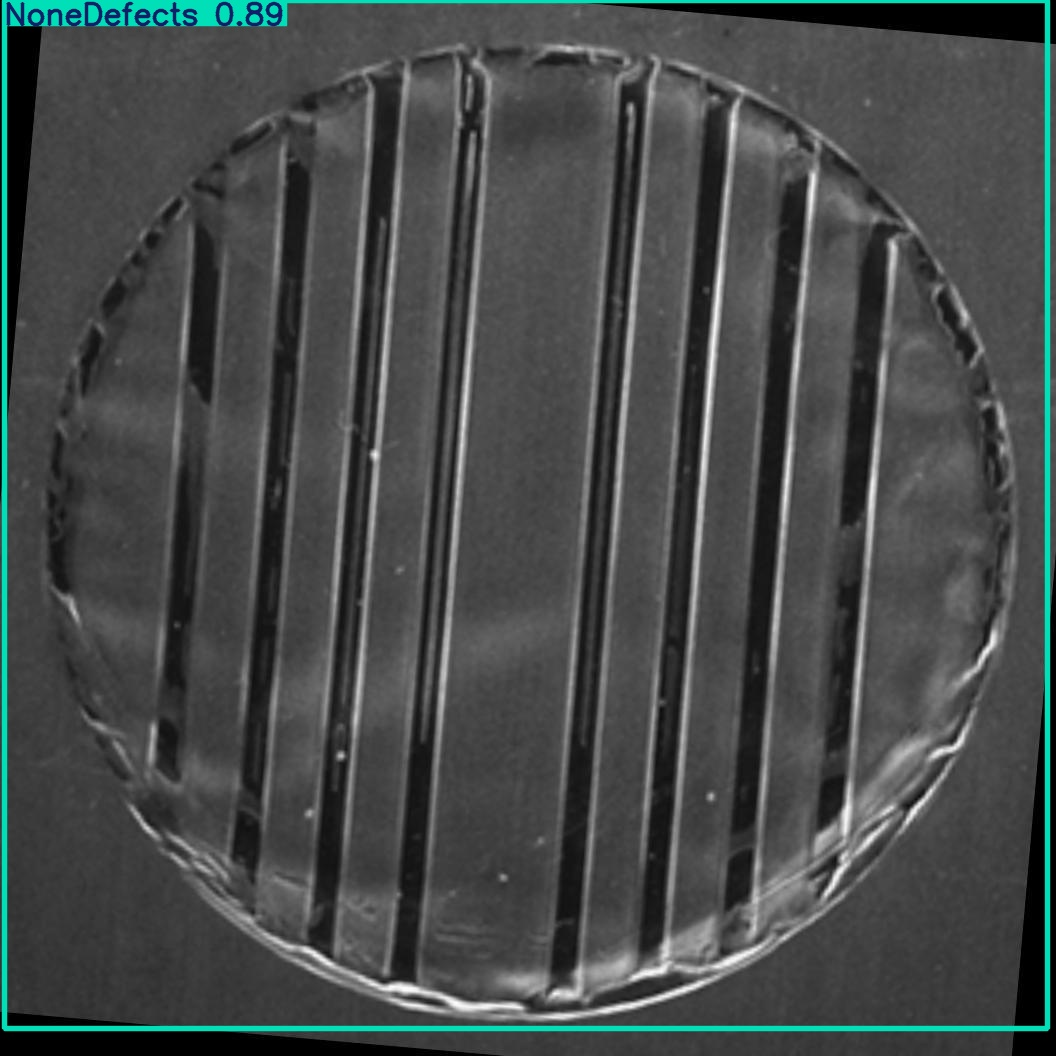

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/datasets/runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

## Развертывание модели на Roboflow

Выгрузка получившегося набора обученных весов из папки `/runs/detect/train/weights/best.pt` в Roboflow Deploy, чтобы была возможность использвать их в дальнейшем.

In [ ]:
project.version(dataset.version(2)).deploy(model_type="yolov8", model_path=f"content/datasets/runs/detect/train/")